In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import sklearn
from sklearn.preprocessing import OneHotEncoder
import math

In [27]:
with open('./2025 Allianz Datathon Dataset.xlsx - Visitation Data.csv') as f:
    reader = csv.reader(f)
    visitation_data = [list(c) for c in zip(*reader)]
visitation_data = visitation_data[:-4] # filtering out empty columns of data

ex_year = visitation_data[0][1:] # year
ex_week = visitation_data[1][1:] # week
ex_daySince2014 = visitation_data[2][1:] # days since 2014

In [208]:
headers = [col[0].strip() for col in visitation_data]
rows = list(zip(*[col[1:] for col in visitation_data]))

df = pd.DataFrame(rows, columns=headers)
df.head()

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^\w\s]", "", regex=True)
              .str.replace(" ", "_")
)

for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="ignore")

for c in ["year", "week"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# datetime column
start_year = 2014
end_year = 2024
season_start_month = 6
season_start_day = 9
weeks_per_season = 15

dates = []
for year in range(start_year, end_year + 1):
    start_date = pd.Timestamp(year=year, month=season_start_month, day=season_start_day)
    # Generate weekly dates
    weekly_dates = [start_date + pd.Timedelta(days=7*i) for i in range(weeks_per_season)]
    dates.extend(weekly_dates)
# Add new datetime column
df["date"] = dates
df = df.drop(columns=["day_since_2014"])

# id columns we want to keep as identifiers
id_cols = ["year", "week", 'date']

# everything else are resorts
resort_cols = [c for c in df.columns if c not in id_cols]
from datetime import date


# reshape
df_visitation_clean = df.melt(
    id_vars=id_cols,
    value_vars=resort_cols,
    var_name="resort",
    value_name="visitors"
)

# visitors as numbers
df_visitation_clean["visitors"] = pd.to_numeric(df_visitation_clean["visitors"], errors="coerce")
df_visitation_clean.head()

C:\Users\haili\AppData\Local\Temp\ipykernel_34960\1765828804.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


,year,week,date,resort,visitors
0,2014,1,2014-06-09,mt_baw_baw,555
1,2014,2,2014-06-16,mt_baw_baw,804
2,2014,3,2014-06-23,mt_baw_baw,993
3,2014,4,2014-06-30,mt_baw_baw,2976
4,2014,5,2014-07-07,mt_baw_baw,11112


# Time series modelling for visitation data

In [241]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.models import AutoARIMA
from darts.models import RNNModel
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

In [211]:
resort_ts_dict = {}
df_visitation_clean['std_date'] = df_visitation_clean['date']-pd.to_timedelta(df_visitation_clean['date'].dt.dayofweek, unit='D')

full_range = pd.date_range(
        start=pd.to_datetime('2014-01-01'),
        end=pd.to_datetime('2024-12-31'), 
        freq='W-MON'
    )
for resort in df_visitation_clean['resort'].unique():
    resort_data = df_visitation_clean[df_visitation_clean['resort'] == resort]
    complete_data = resort_data.set_index('std_date').reindex(full_range, fill_value=0) # zero visitors when the resorts are closed
    complete_data.index.name = 'std_date'
    complete_data = complete_data.reset_index()
    resort_ts_dict[resort] = TimeSeries.from_dataframe(
        complete_data,
        time_col='std_date', 
        value_cols='visitors',
        freq='W-MON'
    )

## Exponential Smoothing

In [216]:
pred_exp_smooth = {}

split_date = pd.Timestamp('2023-01-01')
for key,value in resort_ts_dict.items():
    train, val = resort_ts_dict[key].split_after(split_date)
    # train_in_season = train[train.time_index.month.isin([6,7,8,9])]
    # val_in_season = val[val.time_index.month.isin([6,7,8,9])]
    # Exponential smoothing
    model_exp_smooth = ExponentialSmoothing()
    model_exp_smooth.fit(train)
    pred_exp_smooth[key] = model_exp_smooth.predict(len(val)*2, num_samples=1000)

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


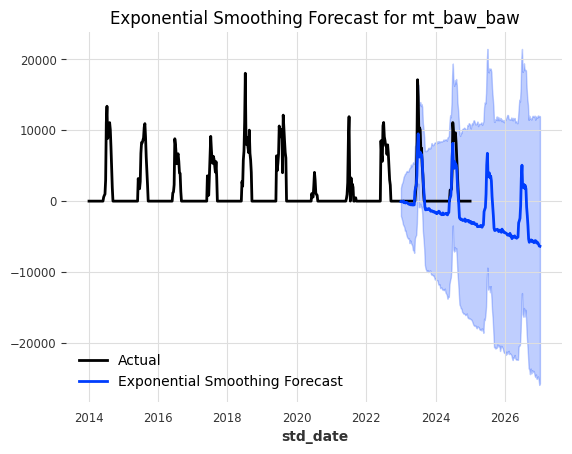

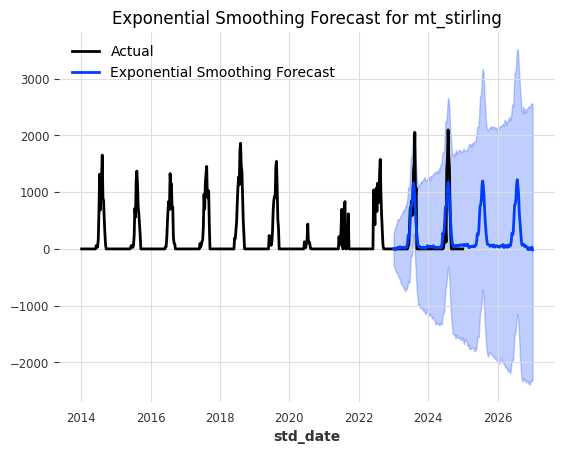

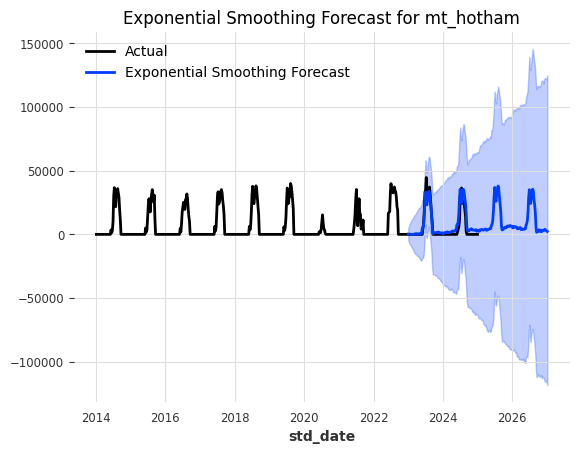

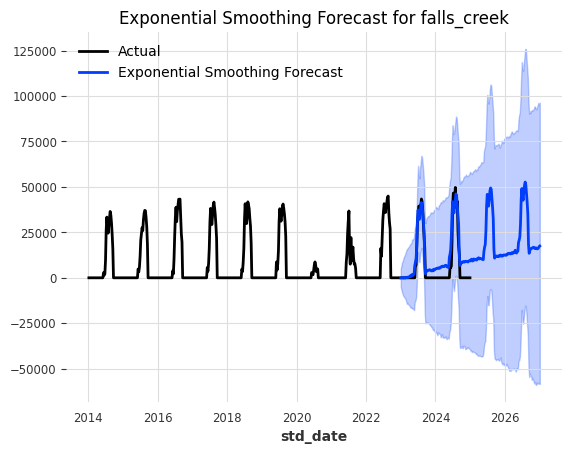

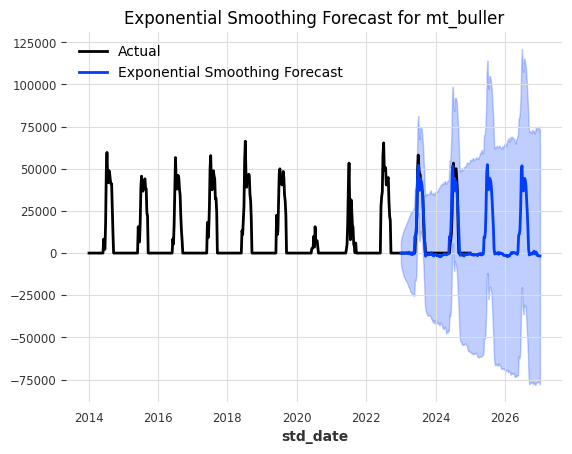

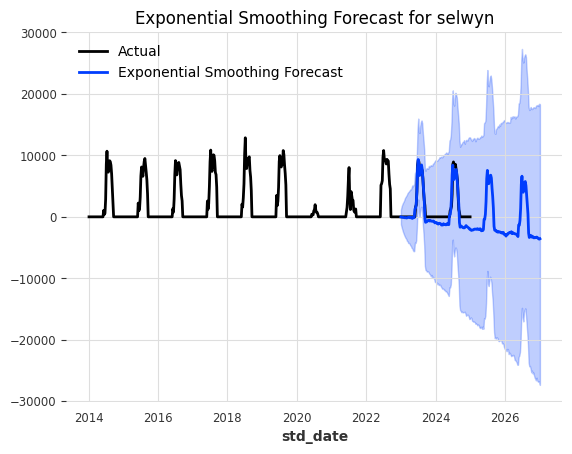

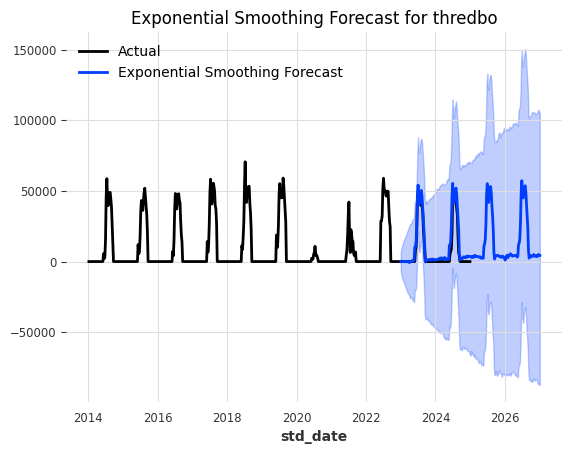

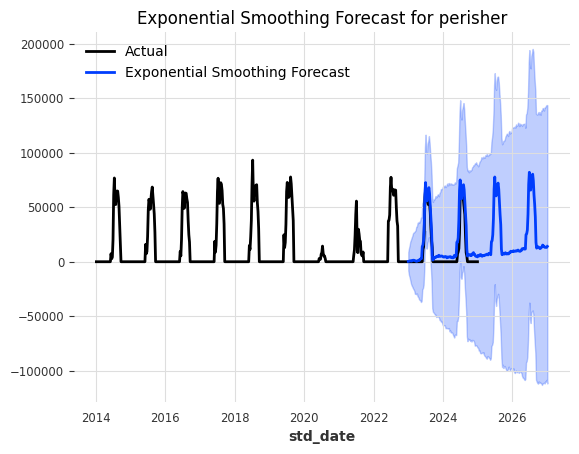

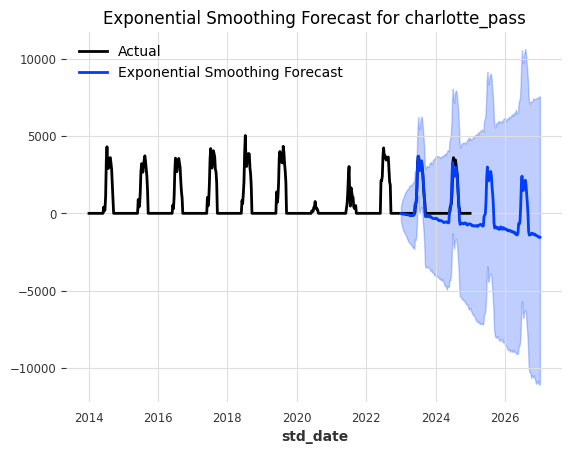

In [218]:
for key in pred_exp_smooth.keys():
    resort_ts_dict[key].plot(label='Actual')
    pred_exp_smooth[key].plot(label='Exponential Smoothing Forecast',  low_quantile = 0.05, high_quantile = 0.95)
    plt.legend()
    plt.title(f'Exponential Smoothing Forecast for {key}')
    plt.show()

comments:
1. Wide CI 
2. non-zero values forecasted for off-season
3. model assumes a linear trend even during off-season which skewed the predictions

Fix?
1. try to put in-season months back to back
2. manually adjust the off-season values to be zero

## AutoARIMA

In [240]:
pred_arima = {}

split_date = pd.Timestamp('2023-01-01')
for key,value in resort_ts_dict.items():
    train, val = resort_ts_dict[key].split_after(split_date)
    model_arima = AutoARIMA(
        seasonal=True,
        season_length=52,   # yearly cycle (weekly data)
        max_p=2, max_q=2,   # allow more flexibility
        max_P=1, max_Q=1,   # seasonal orders
        d=None, D=None,     # let auto-diff decide
        approximation=True,
    )
    model_arima.fit(train)
    pred_arima[key] = model_arima.predict(len(val)*2)

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

loop


C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\U

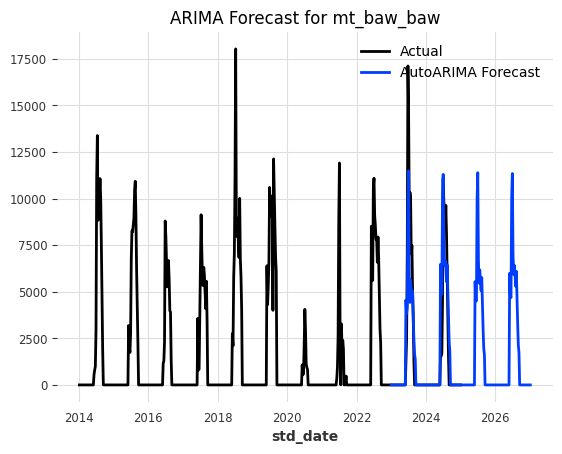

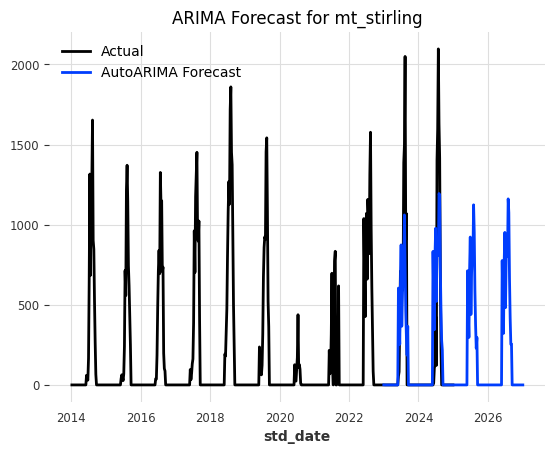

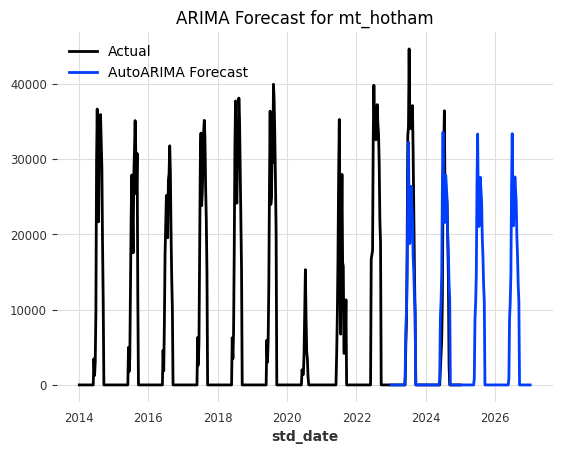

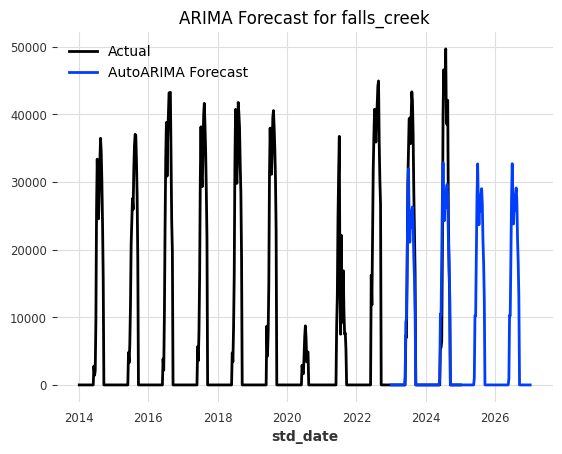

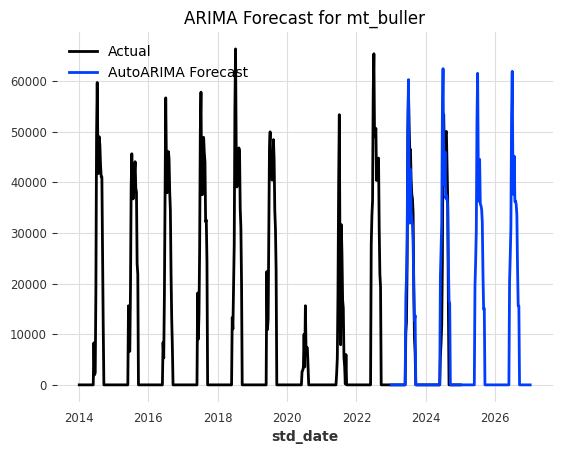

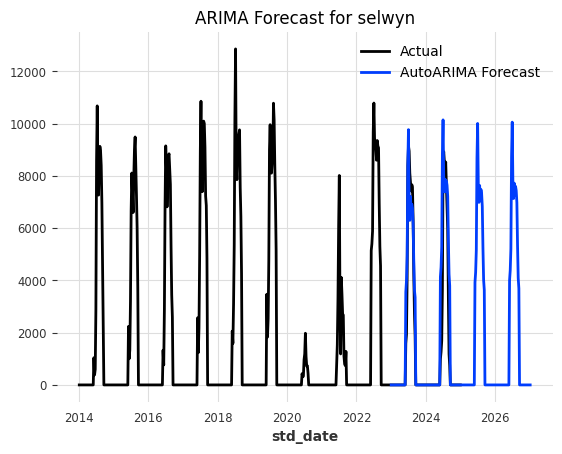

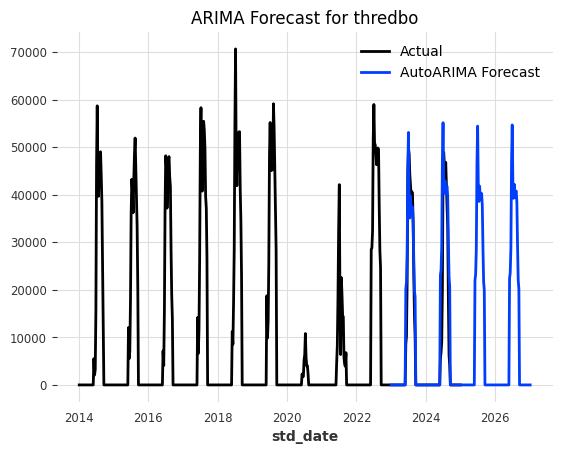

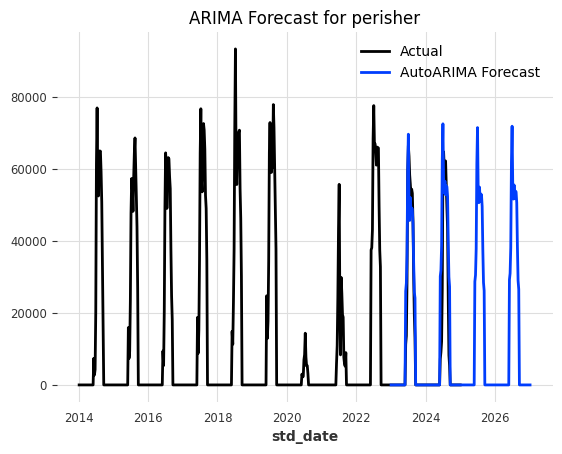

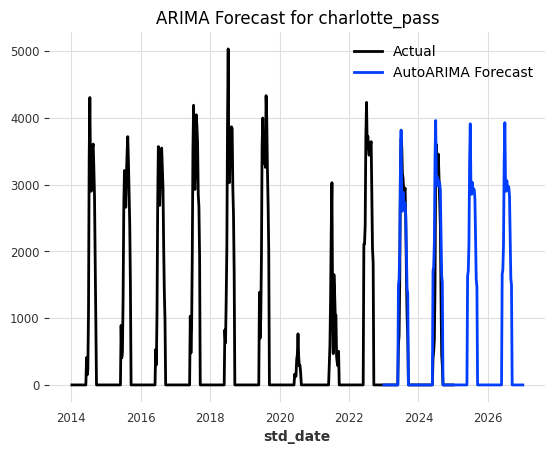

In [238]:
for key in pred_arima.keys():
    resort_ts_dict[key].plot(label='Actual')
    pred_arima[key].plot(label='AutoARIMA Forecast',  low_quantile = 0.05, high_quantile = 0.95)
    plt.legend()
    plt.title(f'ARIMA Forecast for {key}')
    plt.show()

comment:
1. consistent patterns are forecasted -> do not capture external drivers (weather, events, policy, etc)

## RNN - LSTM

In [244]:
pred_rnn = {}
transformer = Scaler()
train_transformed_list = []
split_date = pd.Timestamp('2023-01-01')
for key,value in resort_ts_dict.items():
    train, val = resort_ts_dict[key].split_after(split_date)
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    train_transformed_list.append(train_transformed)
    # model_rnn = RNNModel(model='LSTM', input_chunk_length=52, training_length=52, output_chunk_length=1, n_epochs=1000, random_state=42)
    # model_rnn.fit(train_transformed, verbose=True)
    # pred_rnn[key] = model_rnn.predict(len(val)*2)

In [266]:
model_rnn = RNNModel(model='LSTM', input_chunk_length=52, training_length=52, output_chunk_length=1, n_epochs=1000, random_state=42)
model_rnn.fit(train_transformed_list, verbose=True)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
C:\Users\haili\AppData\Local\Pa

Epoch 999: 100%|██████████| 118/118 [00:06<00:00, 18.25it/s, train_loss=0.000891]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 118/118 [00:06<00:00, 18.18it/s, train_loss=0.000891]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=52, input_chunk_length=52, output_chunk_length=1, n_epochs=1000, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


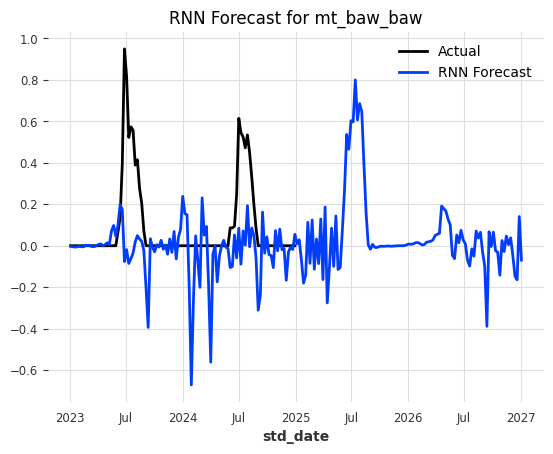

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


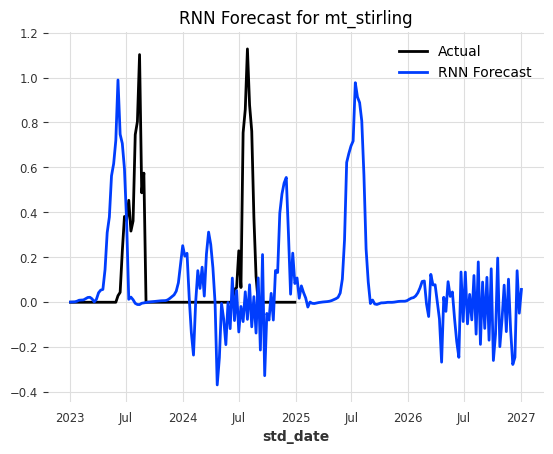

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


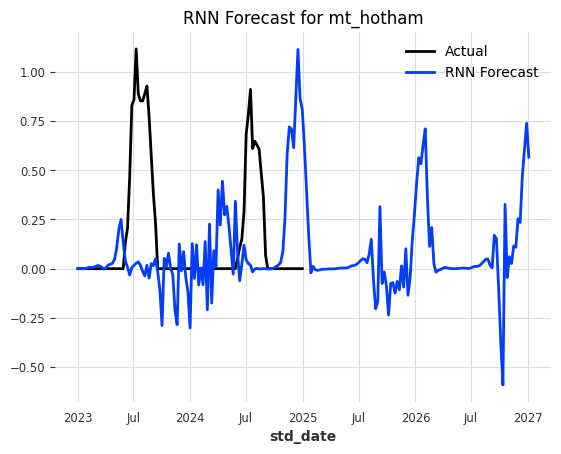

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


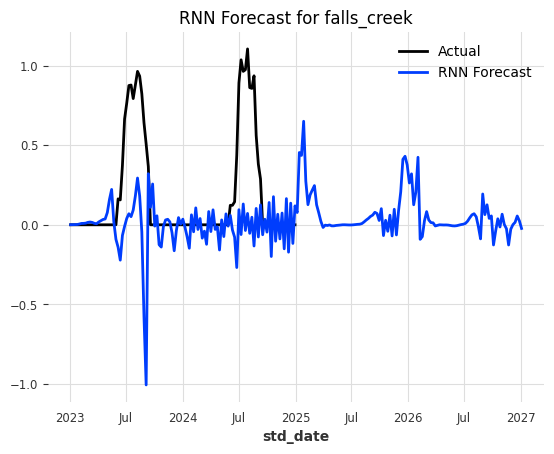

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


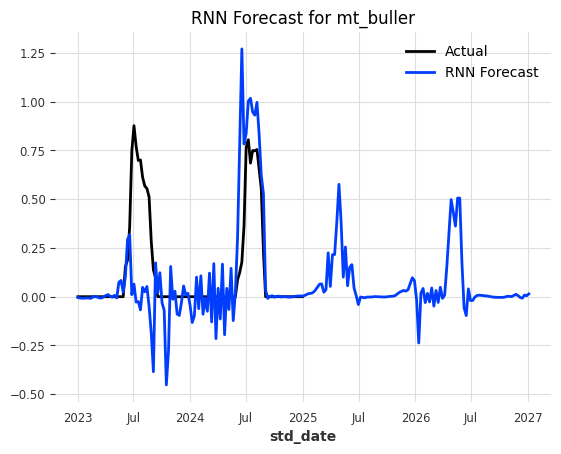

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


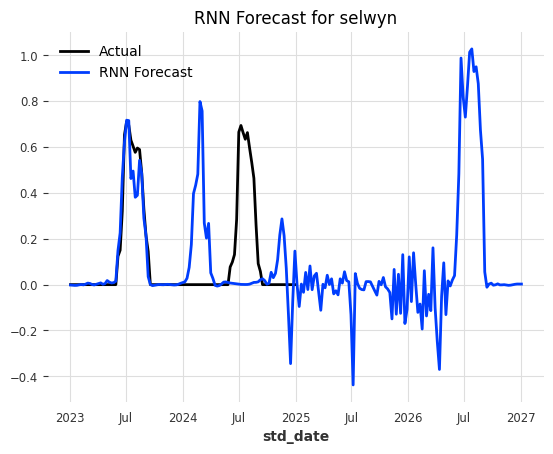

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


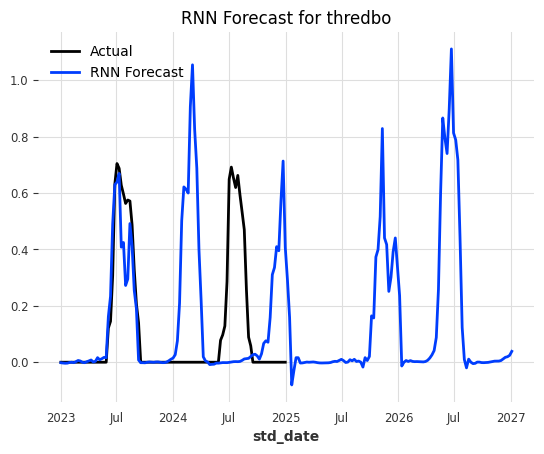

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


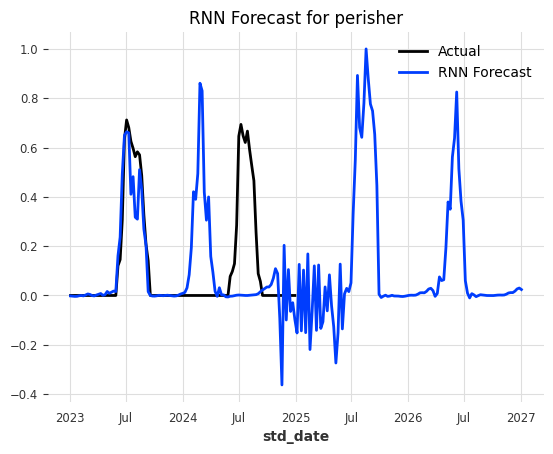

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


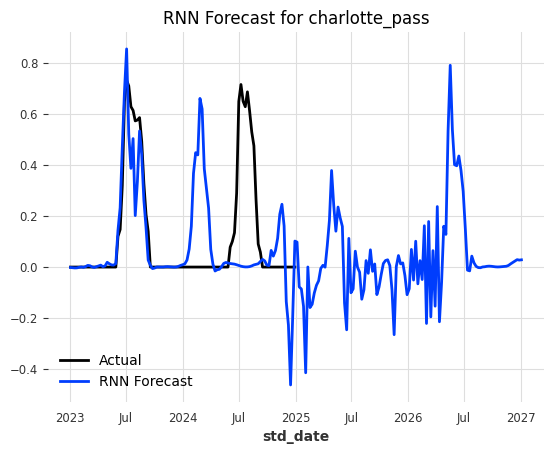

In [267]:
for key in resort_ts_dict.keys():
    train, val = resort_ts_dict[key].split_after(split_date)
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    pred_rnn[key] = model_rnn.predict(n=len(val)*2,series=train_transformed)
    val_transformed.plot(label='Actual')
    pred_rnn[key].plot(label='RNN Forecast')
    plt.legend()
    plt.title(f'RNN Forecast for {key}')
    plt.show()

## Model evaluation and backtesting

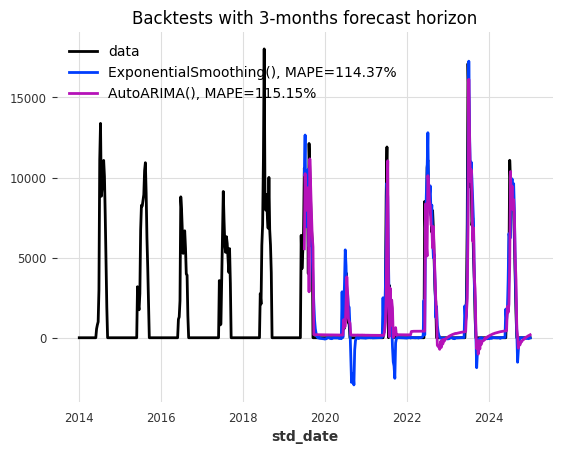

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: Convergen

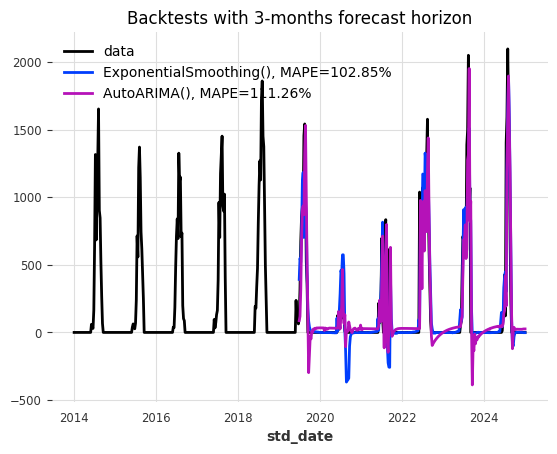

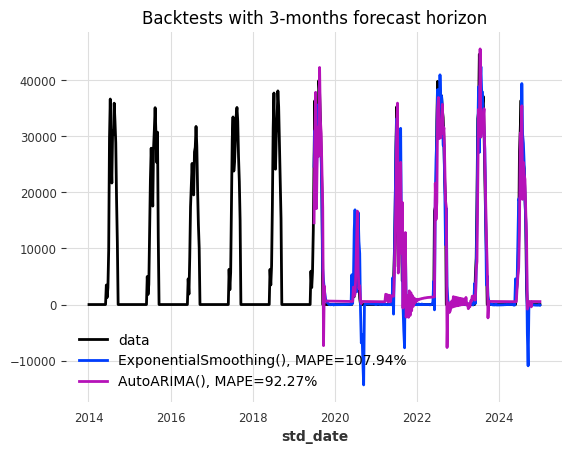

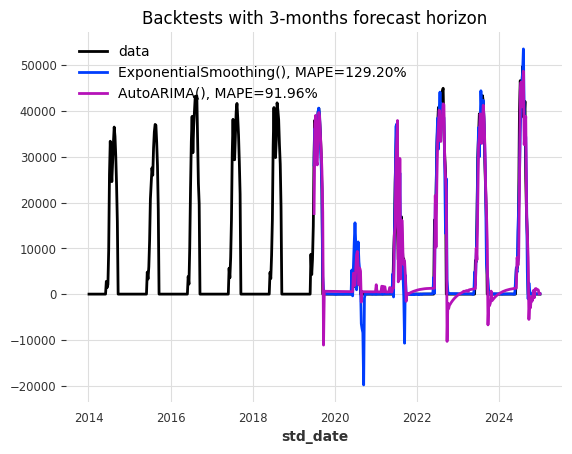

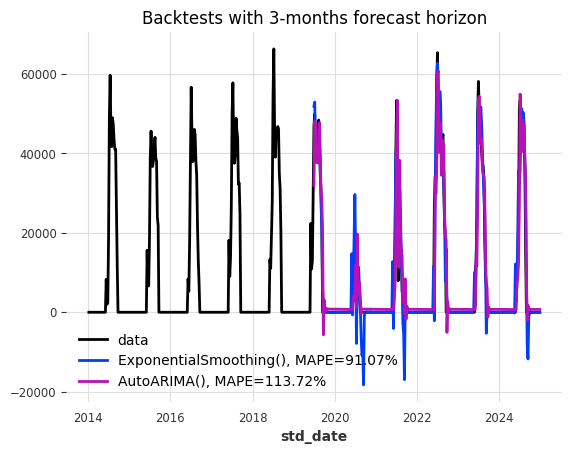

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: Convergen

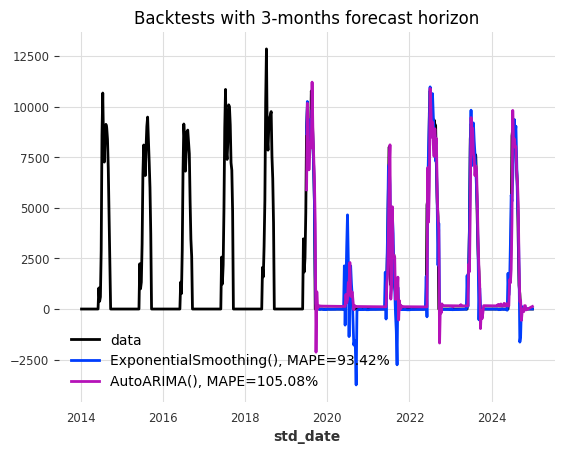

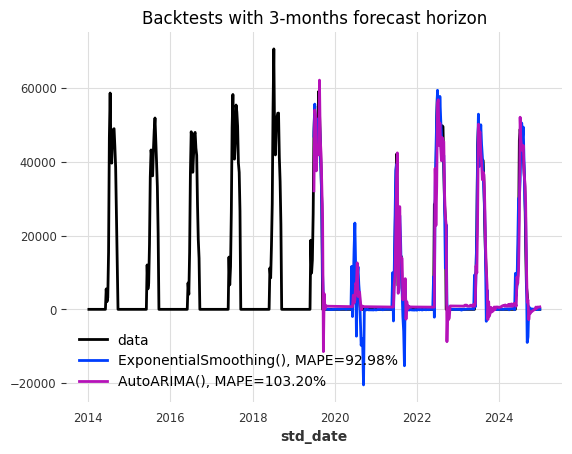

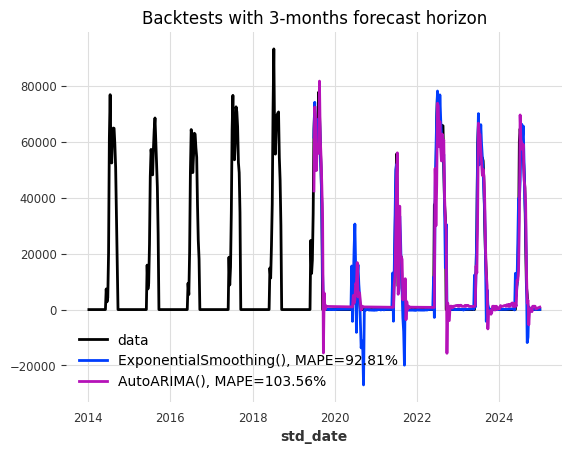

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:903: Convergen

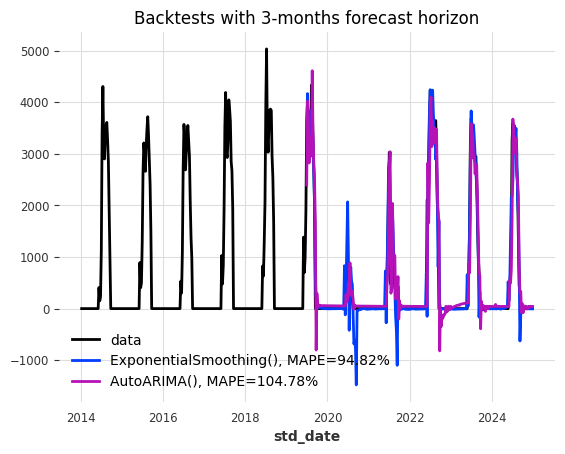

In [ ]:
models = [ExponentialSmoothing(), AutoARIMA()]

for key in resort_ts_dict.keys():
    series = resort_ts_dict[key]
    backtests = [model.historical_forecasts(series, start=.5) for model in models]

    series.plot(label='data')
    for i, m in enumerate(models):
        err = mape(backtests[i], series)
        backtests[i].plot(label='{}, MAPE={:.2f}%'.format(m, err))

    plt.title('Backtests with 3-months forecast horizon')
    plt.legend()
    plt.show()

## Plots comparing Exponential Smoothing and ARIMA forecasts

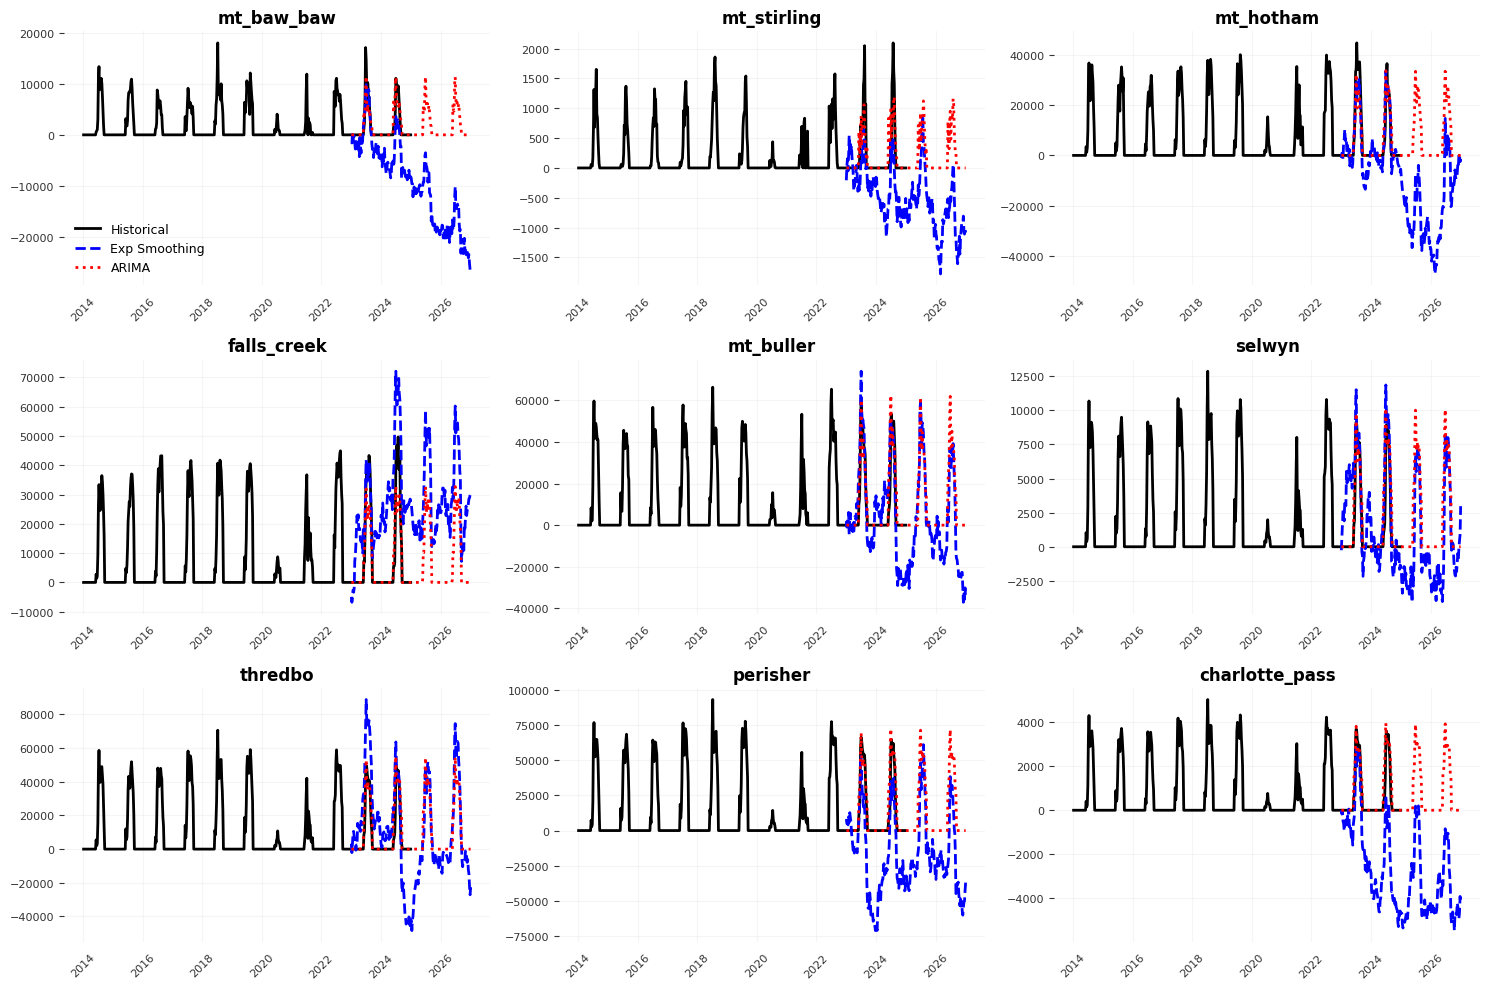

In [276]:
forecast_dict = {}
for key in resort_ts_dict.keys():
    forecast_dict[key] = {
        'historical': resort_ts_dict[key], 
        'exp_smoothing': pred_exp_smooth[key], 
        'arima': pred_arima[key], 
    }

# Create the subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Increased figsize for better readability
axes = axes.flatten()

resort_keys = list(resort_ts_dict.keys())

for i, resort_key in enumerate(resort_keys):
    ax = axes[i]
    resort_data = forecast_dict[resort_key]
    
    # Extract time index and values from TimeSeries objects
    # For historical data
    hist_ts = resort_data['historical']
    ax.plot(hist_ts.time_index, hist_ts.values(), 
            label='Historical', color='black', linewidth=2)
    
    # For exponential smoothing forecast
    exp_ts = resort_data['exp_smoothing']
    ax.plot(exp_ts.time_index, exp_ts.values(), 
            label='Exp Smoothing', color='blue', linewidth=2, linestyle='--')
    
    # For ARIMA forecast
    arima_ts = resort_data['arima']
    ax.plot(arima_ts.time_index, arima_ts.values(), 
            label='ARIMA', color='red', linewidth=2, linestyle=':')
    
    
    # Customize subplot
    ax.set_title(resort_key, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add legend only to first subplot
    if i == 0:
        ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Calculating visitor index

In [354]:
visitor_index_dict = {}
visitor_param = -0.159

filtered_ts_dict = {}
for key in resort_keys:
    filtered_ts_dict[key] = pred_arima[key].drop_before(pd.to_datetime('2026-06-01')).drop_after(pd.to_datetime('2026-09-30'))[:15]

all_data = []
for resort_name, ts in filtered_ts_dict.items():
    dates = ts.time_index
    visitors = ts.values().flatten()  # Flatten to 1D array
     # Create temporary DataFrame for this resort
    resort_df = pd.DataFrame({
        'resort': resort_name,
        'std_date': dates,
        'visitors': visitors
        })
        
    all_data.append(resort_df)
    
    # Concatenate all resort DataFrames
    final_df = pd.concat(all_data, ignore_index=True)

final_df['visitor_index'] = np.exp(visitor_param * final_df['visitors'])
final_df = final_df[final_df['visitors']>0]

In [355]:
final_df

,resort,std_date,visitors,visitor_index
0,mt_baw_baw,2026-06-08,4798.150279,0.000000e+00
1,mt_baw_baw,2026-06-15,4686.139670,4.940656e-324
2,mt_baw_baw,2026-06-22,10065.215800,0.000000e+00
3,mt_baw_baw,2026-06-29,11344.059882,0.000000e+00
4,mt_baw_baw,2026-07-06,7032.285989,0.000000e+00
...,...,...,...,...
129,charlotte_pass,2026-08-10,2957.214709,6.251400e-205
130,charlotte_pass,2026-08-17,2830.770197,3.367656e-196
131,charlotte_pass,2026-08-24,2171.449851,1.135687e-150
132,charlotte_pass,2026-08-31,1595.522160,6.678691e-111


In [356]:
final_df.loc[final_df['visitor_index'].idxmax()]

resort                   mt_stirling
std_date         2026-09-14 00:00:00
visitors                         0.0
visitor_index                    1.0
Name: 29, dtype: object